This project will aim to analyze the complexity with which American presidents in recent history have chosen to communicate to the American people. To somewhat control for context and environment, I will select 3 speeches each president has delivered for the State of the Union Address during their terms. I expect to see a general degradation in speech complexity over the 25+ year span, likely with a significant drop in the 45th and 46th presidencies. 

In [1]:
import requests
from bs4 import BeautifulSoup
import time

Speeches were obtained from www.presidency.ucsb.edu. The State of the Union (SOTU) Address URLs did not appear to follow any discernible pattern unfortunately so I just hardcoded the last 3 SOTUs for each president since Clinton:

In [2]:
sotu_URLS = {
    "Clinton_1998" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-8",
    "Clinton_1999" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-6",
    "Clinton_2000" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-7",

    "Bush_2006" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-13",
    "Bush_2007" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union",
    "Bush_2008" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-18",

    "Obama_2014" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-21",
    "Obama_2015" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-20",
    "Obama_2016" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-19",

    "Trump_2018" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-25",
    "Trump_2019" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-26",
    "Trump_2020" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-27",

    "Biden_2022" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28",
    "Biden_2023" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-29",
    "Biden_2024" : "https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-30"
}

Now to scrape our URLs:

In [3]:

speeches = {}

for key, url in sotu_URLS.items() :
    print(f"Fetching: {url}")
    
    response = requests.get(url)
    if response.status_code == 200 :
        soup = BeautifulSoup(response.text, "html.parser")
        speech_text = soup.find("div", class_="field-docs-content").get_text(separator=" ", strip = True)
        speeches[key] = speech_text
    else:
        print(f"Failed to get {key}")

    time.sleep(1)

for key, text in speeches.items() :
    print(f"{key} (First 200 chars): {text[:200]}\n")  # Check the few lines in each speech



Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-8
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-6
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-7
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-13
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-18
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-21
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-20
Fetching: https://www.presidency.ucsb.edu/documents/address-before-joi

As we can see from the snippets above, the speeches contain things like the president's actions, if notable, or audience reactions. We will need to rid the texts of these instances before continuing with our normal speech preprocessing:

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
def clean_speech(text) :
    text = re.sub(r"\(.*?\)", "", text)  # Removes text inside ()
    text = re.sub(r"\[.*?\]", "", text)  # Removes text inside []
    text = re.sub(r"[^a-zA-Z\s.]", "", text) # Removes non-alphabetical characters, leaves spaces and periods
    text = text.lower() # All lowercase
    
    words = word_tokenize(text) 
    words = [word for word in words if word not in stopwords.words('english')] # Removes stopwords (the, and, etc.)

    lemmatizer = WordNetLemmatizer() # Lemmatize words (ie. proclaiming -> proclaim)
    words = [lemmatizer.lemmatize(word) for word in words]

    cleaned_text = " ".join(words)
    return cleaned_text

In [6]:
cleaned_speeches = {key: clean_speech(text) for key, text in speeches.items()}

In [7]:
for key, text in cleaned_speeches.items() :
    print(f"{key} (First 200 chars): {text[:200]}\n")

Clinton_1998 (First 200 chars): president . mr. speaker mr. vice president member th congress distinguished guest fellow american since last time met chamber america lost two patriot fine public servant . though sat opposite side ai

Clinton_1999 (First 200 chars): mr. speaker mr. vice president member congress honored guest fellow american tonight honor reporting state union . let begin saluting new speaker house thanking especially tonight extending invitation

Clinton_2000 (First 200 chars): mr. speaker mr. vice president member congress honored guest fellow american fortunate alive moment history . never nation enjoyed much prosperity social progress little internal crisis external threa

Bush_2006 (First 200 chars): thank . mr. speaker vice president cheney member congress member supreme court diplomatic corp distinguished guest fellow citizen today nation lost beloved graceful courageous woman called america fou

Bush_2007 (First 200 chars): thank much . tonight high privilege di

Now let's analyze these texts for common indicators of speech complexity. I'll start with sentence length: 

In [8]:
from nltk.tokenize import sent_tokenize

def avg_sentence_length(text) :
    sentences = sent_tokenize(text) # Makes sure abbreviations like "mr." are not counted as a separate sentence
    word_count = sum(len(sentence.split()) for sentence in sentences)

    return word_count / len(sentences) if len(sentences) > 0 else 0 # Get average sentence length

In [9]:
def lexical_diversity(text) :
    words = word_tokenize(text)
    unique_words = set(words)    # Get unique words
    return len(unique_words) / len(words) if len(words) > 0 else 0

In [11]:
import textstat

def readability_score(text) : # Flesh-Kincaid readability score is based on sentence length, syllable count
    return textstat.flesch_kincaid_grade(text) # NOTE: Lower scores mean higher difficulty

In [13]:
import syllapy

def cw_ratio(text) :
    words = word_tokenize(text)
    complex_words = [word for word in words if syllapy.count(word) > 3] # Count words > 3 syllables
    return len(complex_words) / len(words) if len(words) > 0 else 0 # Complex word ratio

c:\Users\jaked\AppData\Local\Programs\Python\Python313\Lib\site-packages\syllapy\data_loader.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [15]:
import pandas as pd

complexity_results = []

for key, text in cleaned_speeches.items():
    president, year = key.split("_")  # Extract president's name and year

    # Compute metrics
    sentence_length = avg_sentence_length(text)
    diversity = lexical_diversity(text)
    readability = readability_score(text)
    cw = cw_ratio(text)

    # Store results
    complexity_results.append({
        "President": president,
        "Year": int(year),
        "Avg Sentence Length" : sentence_length,
        "Lexical Diversity" : diversity,
        "Readability Score" : readability,
        "Complex Word Ratio" : cw
    })

# Convert list to pandas DataFrame
df = pd.DataFrame(complexity_results)

In [16]:
president_avg_df = df.groupby("President", as_index = False).mean()

In [17]:
president_avg_df.head()

,President,Year,Avg Sentence Length,Lexical Diversity,Readability Score,Complex Word Ratio
0,Biden,2023.0,8.300375,0.330259,10.363373,0.080407
1,Bush,2007.0,11.096961,0.413544,12.449180,0.088783
2,Clinton,1999.0,11.159454,0.337466,11.739360,0.090122
3,Obama,2015.0,10.572941,0.380565,11.098984,0.086860
4,Trump,2019.0,9.113838,0.410099,11.902674,0.086234


For my sake, I want to reorder this df in chronological order to make comparisons easier to look at:

In [18]:
president_order = [
    "Clinton",
    "Bush",
    "Obama",
    "Trump",
    "Biden"
]

president_avg_df['President'] = pd.Categorical(president_avg_df['President'], categories = president_order, ordered = True) # Set order of presidents to appear
final_df = president_avg_df.sort_values('President') # Sort by president
final_df.reset_index(drop = True, inplace = True) # Reset the index

final_df.head()

,President,Year,Avg Sentence Length,Lexical Diversity,Readability Score,Complex Word Ratio
0,Clinton,1999.0,11.159454,0.337466,11.739360,0.090122
1,Bush,2007.0,11.096961,0.413544,12.449180,0.088783
2,Obama,2015.0,10.572941,0.380565,11.098984,0.086860
3,Trump,2019.0,9.113838,0.410099,11.902674,0.086234
4,Biden,2023.0,8.300375,0.330259,10.363373,0.080407


Let's plot these results to better understand the differences between presidents over time:

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\jaked\AppData\Local\Temp\ipykernel_14472\3719165578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = final_df, x = "President", y = "Avg Sentence Length", palette = "Blues_r")
C:\Users\jaked\AppData\Local\Temp\ipykernel_14472\3719165578.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = final_df, x = "President", y = "Lexical Diversity", palette = "Greens_r")
C:\Users\jaked\AppData\Local\Temp\ipykernel_14472\3719165578.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = final_df, x = "President", y = "Read

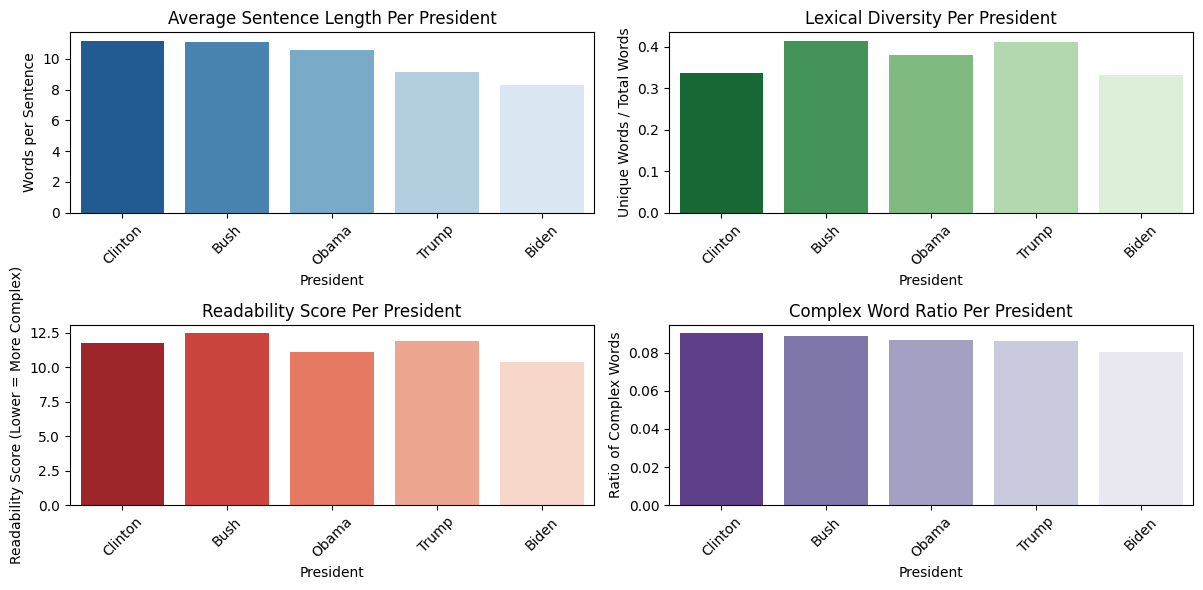

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.barplot(data = final_df, x = "President", y = "Avg Sentence Length", palette = "Blues_r")
plt.xticks(rotation = 45)
plt.title("Average Sentence Length Per President")
plt.ylabel("Words per Sentence")

plt.subplot(2, 2, 2)
sns.barplot(data = final_df, x = "President", y = "Lexical Diversity", palette = "Greens_r")
plt.xticks(rotation = 45)
plt.title("Lexical Diversity Per President")
plt.ylabel("Unique Words / Total Words")

plt.subplot(2, 2, 3)
sns.barplot(data = final_df, x = "President", y = "Readability Score", palette = "Reds_r")
plt.xticks(rotation = 45)
plt.title("Readability Score Per President")
plt.ylabel("Readability Score (Lower = More Complex)")

plt.subplot(2, 2, 4)
sns.barplot(data = final_df, x = "President", y = "Complex Word Ratio", palette = "Purples_r")
plt.xticks(rotation = 45)
plt.title("Complex Word Ratio Per President")
plt.ylabel("Ratio of Complex Words")

plt.tight_layout()
plt.show()

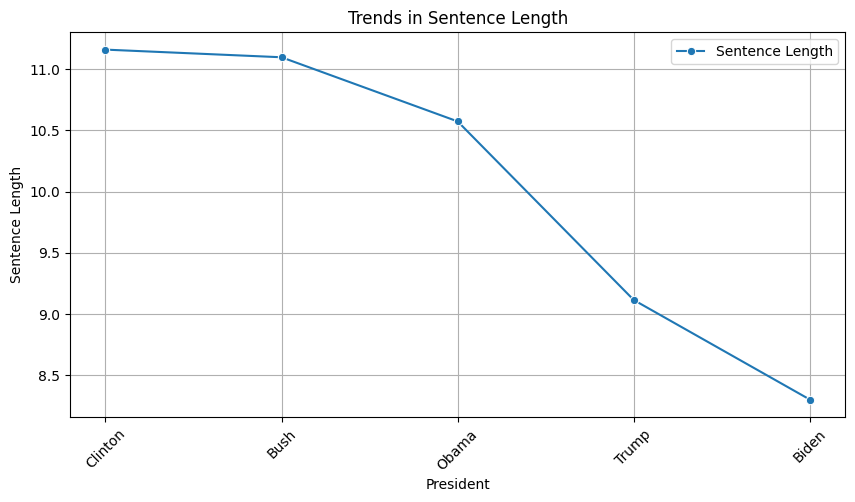

In [22]:
plt.figure(figsize=(10, 5))

sns.lineplot(data = final_df, x = "President", y = "Avg Sentence Length", marker = "o", label = "Sentence Length")
# Sentence length will be plotted separately since it is on a different scale
plt.title("Trends in Sentence Length")
plt.ylabel("Sentence Length")
plt.xlabel("President")
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)

plt.show()


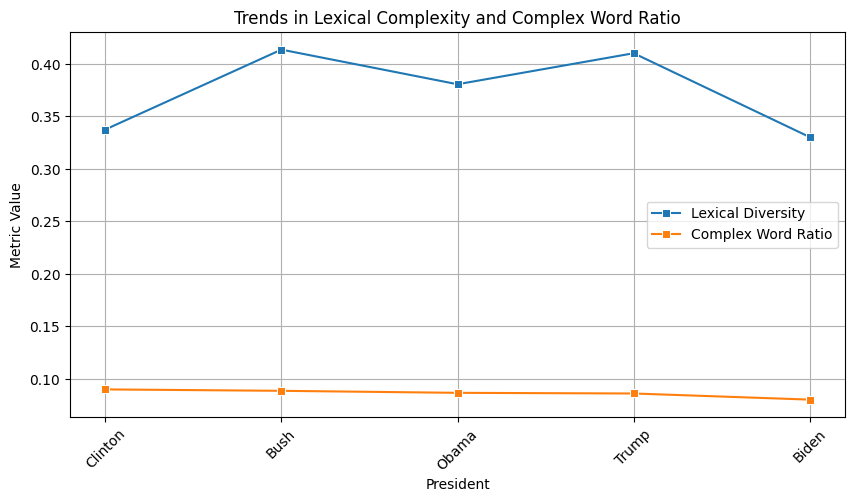

In [23]:
plt.figure(figsize=(10, 5))

sns.lineplot(data = final_df, x = "President", y = "Lexical Diversity", marker = "s", label = "Lexical Diversity")
sns.lineplot(data = final_df, x = "President", y = "Complex Word Ratio", marker = "s", label = "Complex Word Ratio")
# Readability score is excluded as it would be confusing when compared to the other variables
# Readability is the only metric where lower values are more complex, unlike the others
plt.title("Trends in Lexical Complexity and Complex Word Ratio")
plt.ylabel("Metric Value")
plt.xlabel("President")
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)

plt.show()

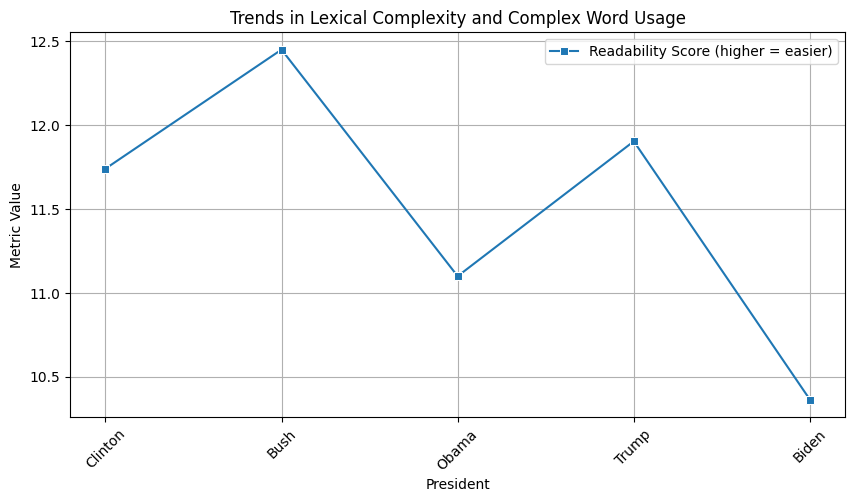

In [24]:
plt.figure(figsize=(10, 5))

sns.lineplot(data = final_df, x = "President", y = "Readability Score", marker = "s", label = "Readability Score (higher = easier)")

plt.title("Trends in Lexical Complexity and Complex Word Usage")
plt.ylabel("Metric Value")
plt.xlabel("President")
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)

plt.show()

We can see some interesting differences in styles between presidents 42-46. Sentence lengths, on average, show a very clear decline which would suggest a simpler communication style. However, this trend does not appear as obvious in other metrics. Lexical complexity does not appear to be decreasing over time, though it does vary by president. Complex word ratios show a consistent decline, though the significance is uncertain at this point. Readability scores appear to run counter to what we might expect given the average sentence length trend; the presidents appear to be getting harder to understand over time, given by the decreasing readability scores. 

I want to quantify our results since the plots, though helpful, were not conclusive:

In [26]:
import scipy.stats as stats

columns = ["Avg Sentence Length", "Lexical Diversity", "Readability Score", "Complex Word Ratio"]

correlation_data = []

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):  # Avoid duplicate calculations
        metric1 = columns[i]
        metric2 = columns[j]
        
        corr, p_value = stats.pearsonr(final_df[metric1], final_df[metric2])
        
        correlation_data.append({"Metric 1": metric1, "Metric 2": metric2, "Correlation": corr, "P-value": p_value})

# Convert list to pandas DataFrame
correlation_results = pd.DataFrame(correlation_data)

print(correlation_results)

              Metric 1            Metric 2  Correlation   P-value
0  Avg Sentence Length   Lexical Diversity     0.234450  0.704246
1  Avg Sentence Length   Readability Score     0.648934  0.236107
2  Avg Sentence Length  Complex Word Ratio     0.917745  0.027967
3    Lexical Diversity   Readability Score     0.718202  0.171781
4    Lexical Diversity  Complex Word Ratio     0.371182  0.538485
5    Readability Score  Complex Word Ratio     0.811421  0.095475


In [27]:
from scipy.stats import ttest_ind

# Clinton and Bush vs Obama, Trump, and Biden on complex word ratio
older_presidents = final_df[final_df["President"].isin(["Clinton", "Bush", "Obama"])]
modern_presidents = final_df[final_df["President"].isin(["Trump", "Biden"])]

# Run t-test on Readability Scores
t_stat, p_value = ttest_ind(older_presidents["Complex Word Ratio"], modern_presidents["Complex Word Ratio"])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.1140358716351852, P-value: 0.1248873802263616


So it doesn't appear that complex word ratio, as it steadily declined with each consecutive president, reached significance. I'm interested in making a single complexity score...

In [31]:
from sklearn.preprocessing import MinMaxScaler

metrics = ["Avg Sentence Length", "Lexical Diversity", "Readability Score", "Complex Word Ratio"]
scaler = MinMaxScaler()
final_df[metrics] = scaler.fit_transform(final_df[metrics])

final_df["Readability Score"] = 1 - final_df["Readability Score"] # Inverting the readability score such that higher score = more complex, like the others

print(final_df[metrics].head())

   Avg Sentence Length  Lexical Diversity  Readability Score  \
0             1.000000           0.086541           0.340309   
1             0.978142           1.000000           0.000000   
2             0.794859           0.604022           0.647325   
3             0.284519           0.958640           0.262012   
4             0.000000           0.000000           1.000000   

   Complex Word Ratio  
0            1.000000  
1            0.862205  
2            0.664262  
3            0.599813  
4            0.000000  


In [32]:
weights = {
    "Avg Sentence Length": 0.35,
    "Lexical Diversity": 0.15,
    "Readability Score": 0.3,
    "Complex Word Ratio": 0.2
}

final_df["Complexity Score"] = (
    final_df["Avg Sentence Length"] * weights["Avg Sentence Length"] +
    final_df["Lexical Diversity"] * weights["Lexical Diversity"] +
    final_df["Readability Score"] * weights["Readability Score"] +
    final_df["Complex Word Ratio"] * weights["Complex Word Ratio"]
)

print(final_df[["President", "Complexity Score"]])

  President  Complexity Score
0   Clinton          0.665074
1      Bush          0.664791
2     Obama          0.695854
3     Trump          0.441944
4     Biden          0.300000


C:\Users\jaked\AppData\Local\Temp\ipykernel_14472\3927183254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = final_df, x = "President", y = "Complexity Score", palette = "magma_r")


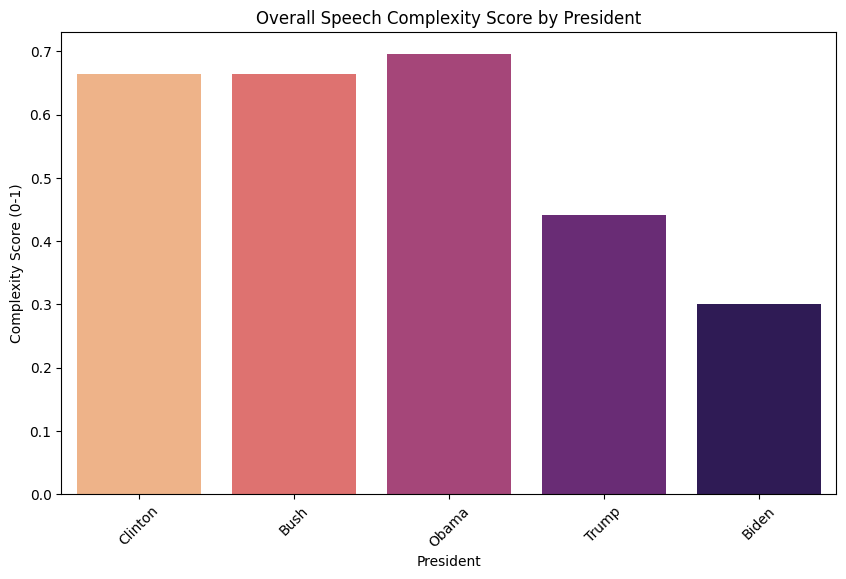

In [33]:
plt.figure(figsize = (10, 6))
sns.barplot(data = final_df, x = "President", y = "Complexity Score", palette = "magma_r")
plt.xticks(rotation = 45)
plt.title("Overall Speech Complexity Score by President")
plt.ylabel("Complexity Score (0-1)")
plt.xlabel("President")
plt.show()

In [34]:
# Older presidents vs modern presidents on overall complexity score
older_presidents = final_df[final_df["President"].isin(["Clinton", "Bush", "Obama"])]
modern_presidents = final_df[final_df["President"].isin(["Trump", "Biden"])]

t_stat, p_value = ttest_ind(older_presidents["Complexity Score"], modern_presidents["Complexity Score"])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 5.578043297420138, P-value: 0.01137437058216214


Overall complexity scores between older presidents (Clinton, Bush and Obama) are significanlty different from our latest two presidents (Biden and Trump). Let's test this further with finding Cohen's d (effect size) and then do a linear regression with time as the predictor variable:

In [35]:
import numpy as np

older_mean = older_presidents["Complexity Score"].mean()
modern_mean = modern_presidents["Complexity Score"].mean()
older_std = older_presidents["Complexity Score"].std()
modern_std = modern_presidents["Complexity Score"].std()

cohen_d = (older_mean - modern_mean) / np.sqrt((older_std**2 + modern_std**2) / 2)

print(f"Cohen's d: {cohen_d}")

Cohen's d: 4.220902188264027


In [37]:
import statsmodels.api as sm

final_df["Year"] = final_df["Year"].astype(int)

# Predict complexity score by year
X = final_df["Year"]
Y = final_df["Complexity Score"]

# Add constant for itercept
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Complexity Score   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     4.254
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.131
Time:                        20:38:40   Log-Likelihood:                 4.3996
No. Observations:                   5   AIC:                            -4.799
Df Residuals:                       3   BIC:                            -5.580
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4726     13.536      2.103      0.1

c:\Users\jaked\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


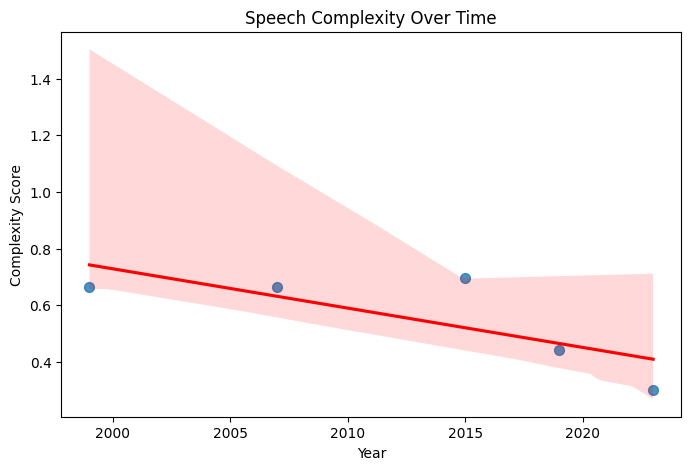

In [38]:
plt.figure(figsize=(8,5))
sns.regplot(data = final_df, x = "Year", y = "Complexity Score", scatter_kws = {'s': 50}, line_kws = {"color": "red"})

plt.title("Speech Complexity Over Time")
plt.xlabel("Year")
plt.ylabel("Complexity Score")
plt.show()

The result of this regression confirms that the relationship between presidential speech complexity over time is not necessarily a linear relationship. Let's try a polynomial regression instead: 

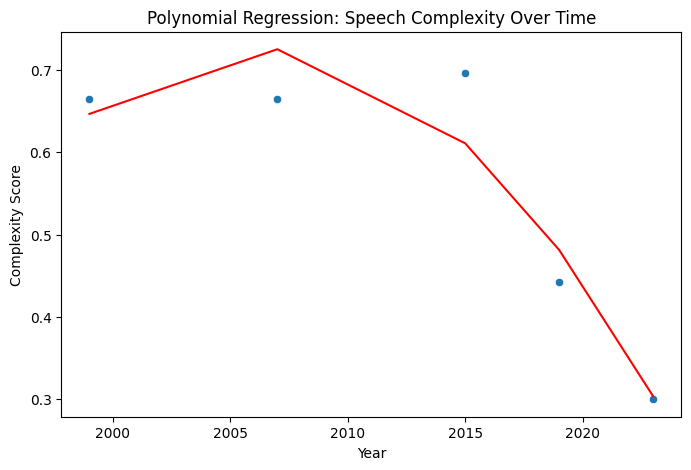

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(final_df[["Year"]])

model = LinearRegression()
model.fit(X_poly, final_df["Complexity Score"])
final_df["Predicted Complexity"] = model.predict(X_poly)

plt.figure(figsize = (8,5))
sns.scatterplot(data = final_df, x = "Year", y = "Complexity Score")
sns.lineplot(data = final_df, x = "Year", y = "Predicted Complexity", color = "red")

plt.title("Polynomial Regression: Speech Complexity Over Time")
plt.show()

In [40]:
X_poly_df = pd.DataFrame(X_poly, columns = ["Intercept", "Year", "Year^2"])  
X_poly_df = sm.add_constant(X_poly_df.drop(columns = ["Intercept"]))
poly_model = sm.OLS(final_df["Complexity Score"], X_poly_df).fit()

print(poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Complexity Score   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     8.532
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.105
Time:                        20:39:15   Log-Likelihood:                 7.8287
No. Observations:                   5   AIC:                            -9.657
Df Residuals:                       2   BIC:                            -10.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6063.8139   2511.647     -2.414      0.1

c:\Users\jaked\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
